In [7]:
from control_system import *
import pandas as pd
from path_planner import *
from lib.dds.dds import *

In [8]:
controller = ControlSystem(x_origin = 12.117, y_origin=6.370, z_origin=0.06)
controller.create_graph('coordinates.csv', 'edges.txt')
controller.start(0, 4)
move_list = controller.move_list

In [9]:
[(move.x_target, move.y_target) for move in move_list if type(move) == XYMovement]

[(11.056, 4.197), (9.483, -0.216), (9.483, -5.159), (3.924, -5.425)]

In [10]:
robot = controller.robot

FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
ATTACH MOVEMENT
ATTACH MOVEMENT
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
FINITO MOVIMENTO
ATTACH MOVEMENT
ATTACH MOVEMENT
FINITO


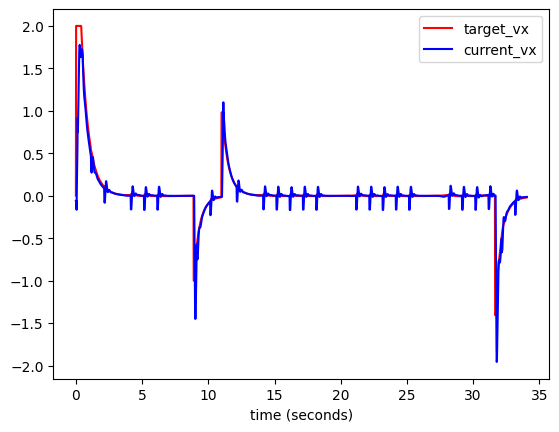

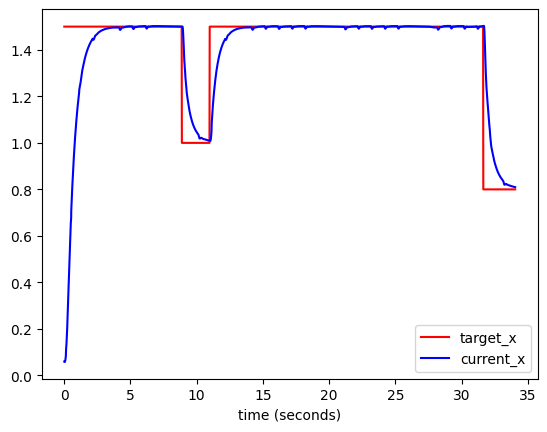

Done


In [11]:
dpvz = DataPlotter()
dpvz.set_x("time (seconds)")
dpvz.add_y("target_vx", "target_vx")
dpvz.add_y("current_vx", "current_vx")

dpz = DataPlotter()
dpz.set_x("time (seconds)")
dpz.add_y("target_x", "target_x")
dpz.add_y("current_x", "current_x")

move_command = move_list.pop(0)
move_command.start()

dds = DDS()
dds.start()

dds.subscribe(['start','tick', 'X', 'Y', 'Z', 'TX', 'TY', 'TZ', 'VX', 'VY', 'VZ', 'WX', 'WY', 'WZ'])


t = Time(use_fake_time=False)
t.start()

while True:
    dds.wait('tick')
    delta_t = t.elapsed()
    
    z = dds.read('Z')
    vz = dds.read('VZ')
    
    x = dds.read('X')
    vx = dds.read('VX')
    
    y = dds.read('Y')
    vy = dds.read('VY')
    
    roll = dds.read('TX')
    roll_rate = dds.read('WX')
    
    pitch = dds.read('TY')
    pitch_rate = dds.read('WY')
    
    if type(move_command) == AttachMovement:
        dds.publish('attached', move_command.evaluate(delta_t), DDS.DDS_TYPE_INT)
        print("ATTACH MOVEMENT")
        
        if move_list == []:
                print("FINITO")
                break
            
        move_command = move_list.pop(0)
        move_command.start()

    else:  
        (f1, f2, f3, f4) = robot.evaluate(delta_t, z, vz, x, vx, y, vy, roll, roll_rate, pitch, pitch_rate)
        move_command.evaluate(delta_t)
        
        if move_command.movement_done():
            print("FINITO MOVIMENTO")
            
            if move_list == []:
                print("FINITO")
                break
                
            move_command = move_list.pop(0)
            move_command.start()

    dds.publish('f1', f1, DDS.DDS_TYPE_FLOAT)
    dds.publish('f2', f2, DDS.DDS_TYPE_FLOAT)
    dds.publish('f3', f3, DDS.DDS_TYPE_FLOAT)
    dds.publish('f4', f4, DDS.DDS_TYPE_FLOAT)
    
    dpvz.append_x(t.get())
    dpvz.append_y("target_vx", robot.vz_target)
    dpvz.append_y("current_vx", vz)

    dpz.append_x(t.get())
    dpz.append_y("target_x", robot.z_target)
    dpz.append_y("current_x", z)


dds.publish('f1', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f2', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f3', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f4', 0, DDS.DDS_TYPE_FLOAT)

dds.stop()
dpvz.plot()
dpz.plot()

print("Done")